# Results for CHR2023 paper

In [12]:
import itertools
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib.cbook import boxplot_stats
import numpy as np

from sklearn.preprocessing import MinMaxScaler, Normalizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA

from scipy.stats import norm

In [13]:
from scipy.stats import percentileofscore


def c2st(X, y, clf=RandomForestClassifier(), loss=accuracy_score, bootstraps=300, alpha_level=0.05):
    """
    Perform Classifier Two Sample Test (C2ST) [1].
    
    This test estimates if a target is predictable from features by comparing the loss of a classifier learning 
    the true target with the distribution of losses of classifiers learning a random target with the same average.
    
    The null hypothesis is that the target is independent of the features - therefore the loss a classifier learning 
    to predict the target should not be different from the one of a classifier learning independent, random noise.
    
    Input:
        - `X` : (n,m) matrix of features
        - `y` : (n,) vector of target - for now only supports binary target
        - `clf` : instance of sklearn compatible classifier (default: `LogisticRegression`)
        - `loss` : sklearn compatible loss function (default: `hamming_loss`)
        - `bootstraps` : number of resamples for generating the loss scores under the null hypothesis
        - `alpha_level`: The alpha level to compute the power of the test for.
    
    Return: (
        loss value of classifier predicting `y`, 
        loss values of bootstraped random targets, 
        p-value of the test
    )
    
    Usage:
    >>> emp_loss, random_losses, pvalue = c2st(X, y)
    
    Plotting H0 and target loss:
    >>>bins, _, __ = plt.hist(random_losses)
    >>>med = np.median(random_losses)
    >>>plt.plot((med,med),(0, max(bins)), 'b')
    >>>plt.plot((emp_loss,emp_loss),(0, max(bins)), 'r--')
    
    [1] Lopez-Paz, D., & Oquab, M. (2016). Revisiting classifier two-sample tests. arXiv preprint arXiv:1610.06545.
    """
    emp_losses = []
    for b in range(bootstraps+1):
        X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)
        y_pred = clf.fit(X_train, y_train).predict(X_test)
        emp_losses.append(loss(y_test, y_pred))
    # take median loss
    emp_loss = np.mean(emp_losses)
    bs_losses = []
    y_bar = np.mean(y)
    for b in range(bootstraps+1):
        y_random = np.random.binomial(1, y_bar, size=y.shape[0])
        X_train, X_test, y_train, y_test = train_test_split(X, y_random)
        y_pred_bs = clf.fit(X_train, y_train).predict(X_test)
        bs_losses += [loss(y_test, y_pred_bs)]
    pc = percentileofscore(sorted(bs_losses), emp_loss) / 100.
    pvalue = pc if pc < y_bar else 1 - pc
    
    # Compute power
    effect = emp_loss - 1/2
    nte = len(y_test)
    power = norm.cdf((effect * np.sqrt(nte) - norm.ppf(1-alpha_level)/2)/np.sqrt(1/4 - effect**2))
    return emp_loss, np.array(bs_losses), pvalue, power

In [14]:
work_df = pd.read_csv("dataset.csv")

In [15]:
pericope_df = []

for pericope in pd.unique(work_df.pericope_name):
    sub_df = work_df[(work_df.pericope_name == pericope) & (~work_df.source.isin(["mark","lucean", "matthean"]))].drop(["book", "pericope_id", "pericope_name", "ix", "source", "genre", "synoptic"], axis=1)
    for i, j in itertools.combinations(sub_df.index, 2):
        diff_vect = np.abs((sub_df.loc[i].values - sub_df.loc[j].values))
        if work_df.loc[i]['book'] == "Mk":
            dist = (sub_df.loc[j].values - sub_df.loc[i].values).tolist()
        elif work_df.loc[j]['book'] == "Mk":
            dist = (sub_df.loc[i].values - sub_df.loc[j].values).tolist()
        else:
            dist = (sub_df.loc[i].values - sub_df.loc[j].values).tolist()
        data = [pericope, f"{work_df.loc[i]['book']}-{work_df.loc[j]['book']}"] + dist
        pericope_df.append(data)

In [16]:
to_drop = ["pericope_name","source","book","genre", "pericope_id"]

distance_vector_pericope = pd.DataFrame(pericope_df)
distance_vector_pericope = distance_vector_pericope.rename(columns={0: "pericope_name", 1: "distance", **{ix + 2: col for ix, col in enumerate(work_df.drop(to_drop + ["ix"], axis=1).columns.tolist())}})
dist_vector = distance_vector_pericope.merge(work_df[to_drop], left_on="pericope_name", right_on="pericope_name", how="left")

dist_vector.drop_duplicates(["pericope_name", "distance"], inplace=True)
null_drop = list(dist_vector.describe().columns[(0 == dist_vector.describe().loc["std"])])
dist_vector = dist_vector.drop(null_drop, axis=1)

### Edit.1: Is there a significant distance between edits of Mark and Luke and Luke and Matthew ?

pvalue: 0.019607843137254943


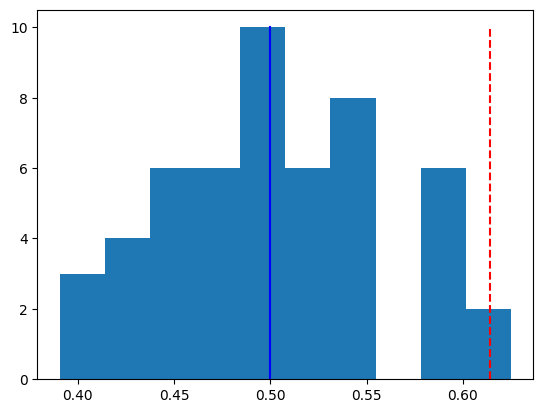

In [18]:
lk = dist_vector[(dist_vector.distance.isin(["Mt-Lk","Mk-Lk"])) & (dist_vector.source.isin(["triple"]))]


pca = PCA(n_components=5)
le = LabelEncoder()

X = lk.drop(to_drop + ["distance"], axis=1)
X_pca = pca.fit_transform(X)
y = le.fit_transform(lk.distance)

emp_loss, random_losses, pvalue, power = c2st(X_pca, y, bootstraps=50)
bins, _, __ = plt.hist(random_losses)

med = np.median(random_losses)
plt.plot((med,med),(0, max(bins)), 'b')
plt.plot((emp_loss,emp_loss),(0, max(bins)), 'r--')

print(f"pvalue: {pvalue}")

### Edit 2.1: Does Matthew's editing style differ significantly from Luke's ?

==== Model pvalue: 0.06930693069306926
==== Model power: 0.3547965338470123


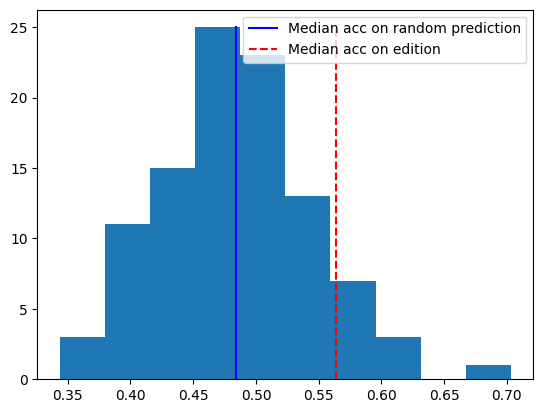

In [112]:
triple = dist_vector[(dist_vector.distance.isin(["Mt-Mk","Mk-Lk"])) & (dist_vector.source.isin(["triple"]))]

rf = DecisionTreeClassifier()
le = LabelEncoder()
pca = PCA(n_components=3)
X = triple.drop(to_drop + ["distance"], axis=1)
X_pca = pca.fit_transform(X)

y = le.fit_transform(triple.distance)

emp_loss, random_losses, pvalue, power = c2st(X_pca, y, bootstraps=100)
bins, _, __ = plt.hist(random_losses)

med = np.median(random_losses)
plt.plot((med,med),(0, max(bins)), 'b', label="Median acc on random prediction")
plt.plot((emp_loss,emp_loss),(0, max(bins)), 'r--', label="Median acc on edition")
plt.legend()


plt.savefig("test_lk_mt.pdf")

print(f"==== Model pvalue: {pvalue}")
print(f"==== Model power: {power}")

### Edit 2.3: Does Matthew's editing style differ significantly from Luke's (narrative) ?

==== Model pvalue: 0.18811881188118817


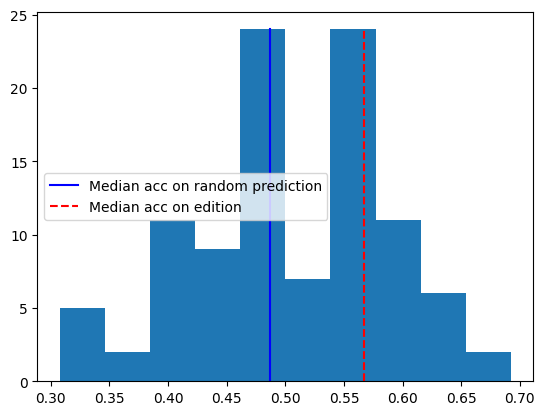

In [31]:
triple = dist_vector[(dist_vector.distance.isin(["Mt-Mk","Mk-Lk"])) & (dist_vector.source.isin(["triple"])) & (dist_vector.genre.isin(["narrative"]))]

rf = DecisionTreeClassifier()
le = LabelEncoder()
pca = PCA(n_components=3)
X = triple.drop(to_drop + ["distance"], axis=1)
X_pca = pca.fit_transform(X)

y = le.fit_transform(triple.distance)

emp_loss, random_losses, pvalue, power = c2st(X_pca, y, bootstraps=100)
bins, _, __ = plt.hist(random_losses)

med = np.median(random_losses)
plt.plot((med,med),(0, max(bins)), 'b', label="Median acc on random prediction")
plt.plot((emp_loss,emp_loss),(0, max(bins)), 'r--', label="Median acc on edition")
plt.legend()

print(f"==== Model pvalue: {pvalue}")


### Edit 2.2: Does Matthew's editing style differ significantly from Luke's (sayings) ?

==== Model pvalue: 0.44554455445544555


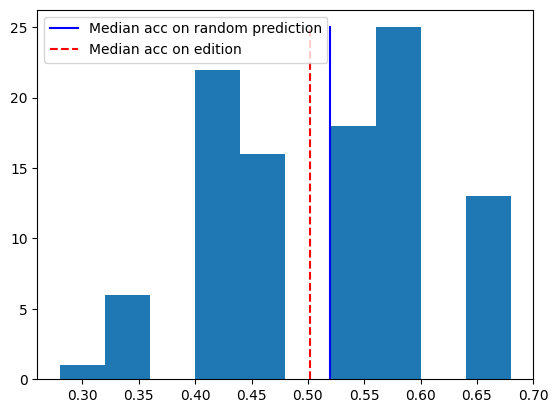

In [29]:
triple = dist_vector[(dist_vector.distance.isin(["Mt-Mk","Mk-Lk"])) & (dist_vector.source.isin(["triple"])) & (dist_vector.genre.isin(["sayings"]))]

rf = DecisionTreeClassifier()
le = LabelEncoder()
pca = PCA(n_components=3)
X = triple.drop(to_drop + ["distance"], axis=1)
X_pca = pca.fit_transform(X)

y = le.fit_transform(triple.distance)

emp_loss, random_losses, pvalue, power = c2st(X_pca, y, bootstraps=100)
bins, _, __ = plt.hist(random_losses)

med = np.median(random_losses)
plt.plot((med,med),(0, max(bins)), 'b', label="Median acc on random prediction")
plt.plot((emp_loss,emp_loss),(0, max(bins)), 'r--', label="Median acc on edition")
plt.legend()


print(f"==== Model pvalue: {pvalue}")

## Stylometric source detection in Luke

### Stylo.0: Stylometric difference between genre

pvalue: 0.0


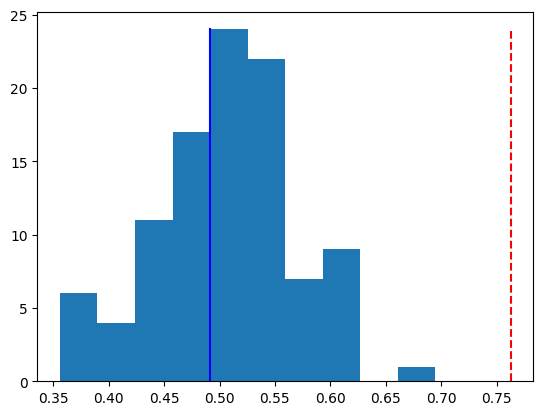

In [25]:
lk = work_df[(work_df.book == "Lk") & (work_df.genre.isin(["narrative", "sayings"]))].set_index("pericope_name")

rf = DecisionTreeClassifier()
pca = PCA(n_components=20)
le = LabelEncoder()
scaler = MinMaxScaler()

X = lk.drop(list(set(to_drop) - set(["pericope_name"])) + ["ix"], axis=1)
X_scaled = scaler.fit_transform(X)
X_pca = pca.fit_transform(X_scaled)
y = le.fit_transform(lk.genre)

emp_loss, random_losses, pvalue, power = c2st(X_pca, y, bootstraps=100)
bins, _, __ = plt.hist(random_losses)

med = np.median(random_losses)
plt.plot((med,med),(0, max(bins)), 'b')
plt.plot((emp_loss,emp_loss),(0, max(bins)), 'r--')

print(f"pvalue: {pvalue}")


### Stylo.1: Stylometric difference between double and triple tradition

pvalue: 0.02970297029702973
==== Model power: 0.9976723085490286


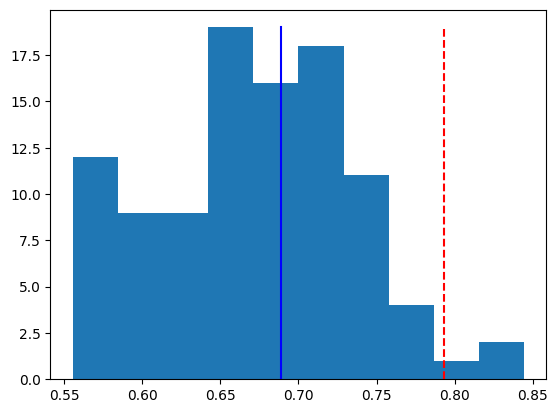

In [58]:
lk = work_df[(work_df.book == "Lk") & (work_df.source.isin(["q", "triple"]))]

rf = DecisionTreeClassifier()
pca = PCA(n_components=20)
le = LabelEncoder()
scaler = MinMaxScaler()

X = lk.drop(list(set(to_drop) - set(["pericope_name"])) + ["ix"], axis=1).set_index("pericope_name")
X_scaled = scaler.fit_transform(X)
X_pca = pca.fit_transform(X_scaled)
y = le.fit_transform(lk.source)

emp_loss, random_losses, pvalue, power = c2st(X_pca, y, bootstraps=100)
bins, _, __ = plt.hist(random_losses)

med = np.median(random_losses)
plt.plot((med,med),(0, max(bins)), 'b')
plt.plot((emp_loss,emp_loss),(0, max(bins)), 'r--')

print(f"pvalue: {pvalue}")
print(f"==== Model power: {power}")

### Stylo.2: Stylometric difference between double - triple tradition on sayings

pvalue: 0.04950495049504955
==== Model power: 0.6534171188658817


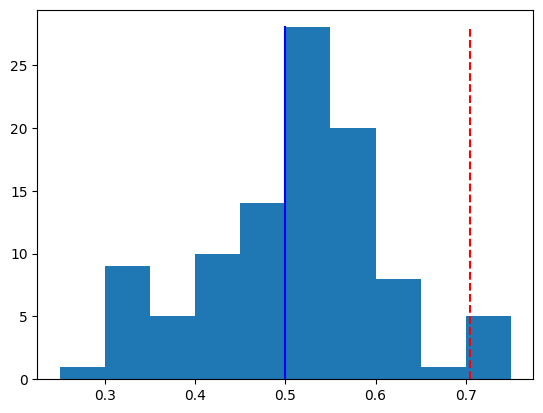

In [8]:
lk = work_df[(work_df.book == "Lk") & (work_df.source.isin(["q", "triple"])) & work_df.genre.isin(["sayings"])]

rf = DecisionTreeClassifier()
pca = PCA(n_components=20)
le = LabelEncoder()
scaler = MinMaxScaler()

X = lk.drop(list(set(to_drop) - set(["pericope_name"])) + ["ix"], axis=1).set_index("pericope_name")
X_scaled = scaler.fit_transform(X)
X_pca = pca.fit_transform(X_scaled)
y = le.fit_transform(lk.source)

emp_loss, random_losses, pvalue, power = c2st(X_pca, y, bootstraps=100)
bins, _, __ = plt.hist(random_losses)

med = np.median(random_losses)
plt.plot((med,med),(0, max(bins)), 'b')
plt.plot((emp_loss,emp_loss),(0, max(bins)), 'r--')

print(f"pvalue: {pvalue}")
print(f"==== Model power: {power}")

In [197]:
rf = RandomForestClassifier()

X_train, X_test, y_train, y_test = train_test_split(X, y)

rf.fit(X_train, y_train)

print(accuracy_score(rf.predict(X_test), y_test))

forest_importances = pd.Series(rf.feature_importances_, index=X.columns)

print(forest_importances.sort_values(ascending=False).head(5).to_latex().replace("\\\n", "\\ \hline\n").replace("_", "-"))

0.68
\begin{tabular}{lr}
\toprule
 & 0 \\ \hline
\midrule
tense-I & 0.065946 \\ \hline
capitalized-words & 0.041571 \\ \hline
count-αὐτός & 0.039025 \\ \hline
avg-word-length & 0.034037 \\ \hline
avg-len-comma & 0.027597 \\ \hline
\bottomrule
\end{tabular}



pvalue: 0.2524752475247525


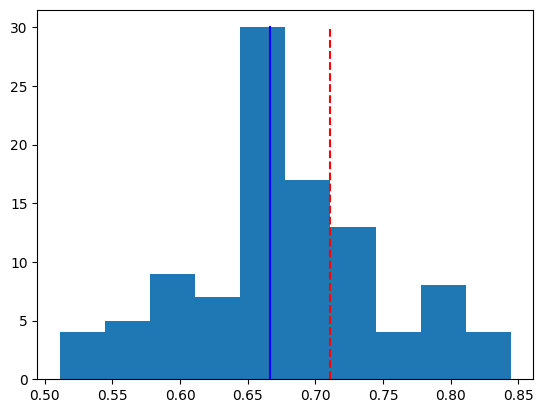

In [167]:
lk = work_df[(work_df.book == "Lk") & (work_df.source.isin(["triple", "lucean"]))]


rf = DecisionTreeClassifier()
pca = PCA(n_components=20)
le = LabelEncoder()
scaler = MinMaxScaler()

X = lk.drop(to_drop + ["ix"], axis=1)
X_scaled = scaler.fit_transform(X)
X_pca = pca.fit_transform(X_scaled)
y = le.fit_transform(lk.source)

emp_loss, random_losses, pvalue, power = c2st(X_pca, y, bootstraps=100)
bins, _, __ = plt.hist(random_losses)

med = np.median(random_losses)
plt.plot((med,med),(0, max(bins)), 'b')
plt.plot((emp_loss,emp_loss),(0, max(bins)), 'r--')

print(f"pvalue: {pvalue}")
print(f"==== Model power: {power}")

In [216]:
pericope = "The Healing of Peter's Mother-in-law"

print(work_df[work_df.pericope_name == pericope][["book", "nbr_words", "capitalized_words", "count_καί"]].to_latex(float_format="%.0f", index=False).replace("\\\n", "\\ \hline\n").replace("_", "-"))

\begin{tabular}{lrrr}
\toprule
book & nbr-words & capitalized-words & count-καί \\ \hline
\midrule
Mt & 33 & 2 & 6 \\ \hline
Mk & 48 & 5 & 7 \\ \hline
Lk & 41 & 2 & 3 \\ \hline
\bottomrule
\end{tabular}



In [236]:
work_df[work_df.pericope_name == pericope]

,book,pericope_id,pericope_name,ix,pos_N,number_S,case_N,case_G,gender_M,gender_F,...,pos_RI,pos_X,tense_F,mode_D,mode_O,tense_Y,pos_I,source,genre,synoptic
70,Mt,37,The Healing of Peter's Mother-in-law,37|The Healing of Peter's Mother-in-law|Mt,6.0,23.0,5.0,5.0,8.0,10.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,triple,narrative,True
71,Mk,37,The Healing of Peter's Mother-in-law,37|The Healing of Peter's Mother-in-law|Mk,10.0,28.0,10.0,10.0,14.0,12.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,triple,narrative,True
72,Lk,37,The Healing of Peter's Mother-in-law,37|The Healing of Peter's Mother-in-law|Lk,7.0,25.0,5.0,7.0,11.0,10.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,triple,narrative,True


In [217]:
print(dist_vector[dist_vector.pericope_name == pericope][["distance", "nbr_words", "capitalized_words", "count_καί"]].to_latex(float_format="%.2f", index=False).replace("\\\n", "\\ \hline\n").replace("_", "-"))

\begin{tabular}{lrrr}
\toprule
distance & nbr-words & capitalized-words & count-καί \\ \hline
\midrule
Mt-Mk & -15.00 & -3.00 & -1.00 \\ \hline
Mt-Lk & -8.00 & 0.00 & 3.00 \\ \hline
Mk-Lk & -7.00 & -3.00 & -4.00 \\ \hline
\bottomrule
\end{tabular}



In [237]:
pericope = "The Beatitudes"
print(work_df[work_df.pericope_name == pericope][["book", "nbr_words", "case_N", "gender_F"]].to_latex(float_format="%.0f", index=False).replace("\\\n", "\\ \hline\n").replace("_", "-"))

\begin{tabular}{lrrr}
\toprule
book & nbr-words & case-N & gender-F \\ \hline
\midrule
Mt & 118 & 41 & 11 \\ \hline
Lk & 89 & 22 & 6 \\ \hline
\bottomrule
\end{tabular}



In [239]:
work_df[work_df.pericope_name == pericope].pericope_id

110    51
111    51
Name: pericope_id, dtype: object

In [215]:
print(dist_vector[dist_vector.pericope_name == pericope][["distance", "nbr_words", "case_N", "gender_F"]].to_latex(float_format="%.2f", index=False).replace("\\\n", "\\ \hline\n").replace("_", "-"))

\begin{tabular}{lrrr}
\toprule
distance & nbr-words & case-N & gender-F \\ \hline
\midrule
Mt-Lk & 29.00 & 19.00 & 5.00 \\ \hline
\bottomrule
\end{tabular}

